<a href="https://colab.research.google.com/github/nrajmalwar/Deep-Learning-Projects/blob/master/One-shot%20Learning%20for%20Omniglot%20Dataset/Omniglot_One_Shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.utils import plot_model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rnd

from IPython.display import Image

Using TensorFlow backend.


# Load Dataset

In [0]:
# Download the train and test dataset

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2019-06-29 14:16:25--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2019-06-29 14:16:25--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip.1’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.09s   

2019-06-29 14:16:26 (66.4 MB/s) - ‘images_evaluation.zip.1’ saved

In [0]:
# Unzip the files and save in Colab Disk Storage
!unzip -qq 'images_evaluation.zip'
!unzip -qq 'images_background.zip'

In [0]:
!ls

data		   images_background.zip  images_evaluation.zip
images_background  images_evaluation	  sample_data


In [0]:
# Path for train and validation folder

train_folder = 'images_background'
val_folder = 'images_evaluation'

In [0]:
def loadimgs(path, n = 0):
    '''
    Function: To load the images the images from train or validation directory

    Parameters: path- path of the train or validation directory, n - indexing of y_labels
    
    Return: X - the folder of images of alphabets
            y - the labels of images
            lang_dict - dictionary of language, the key is the language alphabet and the values are the letters of the alphabet
    '''
    
    X = []
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # Load every alphabet from the directory
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y, None]
        alphabet_path = os.path.join(path, alphabet)
        
        # Every letter in the alphabet has its own set of images, so load the images individually
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # Read all the images of the particular letter
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = plt.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
            
    y = np.vstack(y)
    X = np.stack(X)
    
    return X, y, lang_dict

## Load Train Images

In [0]:
# Load the train images from the train folder

X_train, y_train, c_train = loadimgs(train_folder)

loading alphabet: Balinese
loading alphabet: Gujarati
loading alphabet: Tagalog
loading alphabet: Early_Aramaic
loading alphabet: Braille
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Futurama
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Latin
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Hebrew
loading alphabet: Tifinagh
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: N_Ko
loading alphabet: Japanese_(katakana)
loading alphabet: Armenian
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Sanskrit
loading alphabet: Cyrillic
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Korean
loading alphabet: Japanese_(hiragana)
loading alphabet: Bengali
loading alphabet: Arcadian
loading alphabet: Burmese_(Myanmar)
loading alphabet: Mkhedruli_(Georgian)


In [0]:
# The train dataset consists of 30 alphabets. In total, there are 964 classes (or characters). Each class has 20 images of size 105x105.
print(X_train.shape) 

# Total number of images is 964*20 = 19280
print(y_train.shape)

# Dictionary of the alphabet. Keys are the languages and values are the range of letters
print(c_train)

(964, 20, 105, 105)
(19280, 1)
{'Balinese': [0, 23], 'Gujarati': [24, 71], 'Tagalog': [72, 88], 'Early_Aramaic': [89, 110], 'Braille': [111, 136], 'Asomtavruli_(Georgian)': [137, 176], 'Futurama': [177, 202], 'Syriac_(Estrangelo)': [203, 225], 'Alphabet_of_the_Magi': [226, 245], 'Latin': [246, 271], 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [272, 285], 'Malay_(Jawi_-_Arabic)': [286, 325], 'Anglo-Saxon_Futhorc': [326, 354], 'Hebrew': [355, 376], 'Tifinagh': [377, 431], 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [432, 445], 'N_Ko': [446, 478], 'Japanese_(katakana)': [479, 525], 'Armenian': [526, 566], 'Grantha': [567, 609], 'Greek': [610, 633], 'Sanskrit': [634, 675], 'Cyrillic': [676, 708], 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [709, 724], 'Korean': [725, 764], 'Japanese_(hiragana)': [765, 816], 'Bengali': [817, 862], 'Arcadian': [863, 888], 'Burmese_(Myanmar)': [889, 922], 'Mkhedruli_(Georgian)': [923, 963]}


## Load Validation Images

In [0]:
# Load the validation images from the validation folder

X_val, y_val, c_val = loadimgs(val_folder)

loading alphabet: Glagolitic
loading alphabet: Sylheti
loading alphabet: Angelic
loading alphabet: Oriya
loading alphabet: Tibetan
loading alphabet: Mongolian
loading alphabet: Avesta
loading alphabet: Atlantean
loading alphabet: Syriac_(Serto)
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Atemayar_Qelisayer
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Ge_ez
loading alphabet: Keble
loading alphabet: Gurmukhi
loading alphabet: ULOG
loading alphabet: Aurek-Besh
loading alphabet: Manipuri
loading alphabet: Kannada


In [0]:
# The train dataset consists of 20 alphabets. In total, there are 659 classes (or characters). Each class has 20 images of size 105x105.
print(X_val.shape) 

# Total number of images is 659*20 = 13180
print(y_val.shape)

# Dictionary of the alphabet. Keys are the languages and values are the range of letters
print(c_val)

(659, 20, 105, 105)
(13180, 1)
{'Glagolitic': [0, 44], 'Sylheti': [45, 72], 'Angelic': [73, 92], 'Oriya': [93, 138], 'Tibetan': [139, 180], 'Mongolian': [181, 210], 'Avesta': [211, 236], 'Atlantean': [237, 262], 'Syriac_(Serto)': [263, 285], 'Tengwar': [286, 310], 'Malayalam': [311, 357], 'Atemayar_Qelisayer': [358, 383], 'Old_Church_Slavonic_(Cyrillic)': [384, 428], 'Ge_ez': [429, 454], 'Keble': [455, 480], 'Gurmukhi': [481, 525], 'ULOG': [526, 551], 'Aurek-Besh': [552, 577], 'Manipuri': [578, 617], 'Kannada': [618, 658]}


# Build a Siamese Network

In [0]:
def get_siamese_model(input_shape):
    """
        Build a Siamese Network Model Architecture based on the paper: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Sequential model for the Convolutional Neural Network
    
    model = Sequential()
    
    # Input Shape = 105x105x1
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4))) 
    # Output Shape: 96x96x64
    
    model.add(MaxPooling2D())
    # Output Shape: 48x48x64
    
    model.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
    # Output Shape: 42x42x128
    
    model.add(MaxPooling2D())
    # Output Shape: 21x21x128
    
    model.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    # Output Shape: 18x18x128
    
    model.add(MaxPooling2D())
    # Output Shape: 9x9x128
    
    model.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    # Output Shape: 6x6x256
      
    model.add(Flatten())    
    # Output Shape: 9216x1
    
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3)))
    # Output Shape: 4096x1
    
    # Generate the encodings (feature vectors) for the two images
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    
    siamese_net = Model(inputs = [left_input, right_input], outputs = prediction)
    
    # Return the model
    
    return siamese_net

In [0]:
# Build the model for an input size of 105x105x1

model = get_siamese_model((105, 105, 1))

# Print the model summary

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

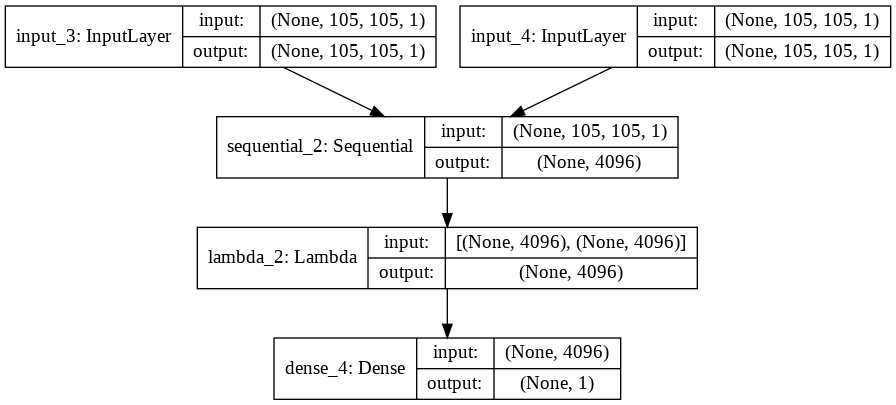

In [0]:
plot_model(model, show_shapes=True, to_file='model.png')
Image('model.png')

# Model Compilation

In [0]:
# Use Adam Optimizer with very low learning rate
optimizer = Adam(lr = 0.00006)

# Compile the model with loss function as binary crossentropy
model.compile(loss="binary_crossentropy", optimizer=optimizer)

# Load Train Tensors

In [0]:
print("Training alphabets: \n")
print(list(c_train.keys()))

Training alphabets: 

['Cyrillic', 'Hebrew', 'Tagalog', 'Malay_(Jawi_-_Arabic)', 'Futurama', 'Alphabet_of_the_Magi', 'Tifinagh', 'Grantha', 'Mkhedruli_(Georgian)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Latin', 'Bengali', 'Balinese', 'Sanskrit', 'Korean', 'Gujarati', 'Japanese_(hiragana)', 'N_Ko', 'Arcadian', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Asomtavruli_(Georgian)', 'Braille', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Syriac_(Estrangelo)', 'Greek', 'Armenian', 'Early_Aramaic', 'Anglo-Saxon_Futhorc', 'Burmese_(Myanmar)']


In [0]:
print("Validation alphabets:", end="\n\n")
print(list(c_val.keys()))

Validation alphabets:

['Oriya', 'Syriac_(Serto)', 'Atlantean', 'Keble', 'Old_Church_Slavonic_(Cyrillic)', 'Glagolitic', 'Tibetan', 'ULOG', 'Ge_ez', 'Manipuri', 'Sylheti', 'Aurek-Besh', 'Tengwar', 'Gurmukhi', 'Kannada', 'Mongolian', 'Malayalam', 'Atemayar_Qelisayer', 'Angelic', 'Avesta']


# Model Functions

## get_batch Function

1. Function: Create batch of n pairs, half same class, half different class
2. Parameters: batch_size- size of the batch;                s - sample from train or validation data
3. Return: pairs, targets - Pairs of images and their targets

In [0]:
def get_batch(batch_size, s="train"):
       
    if s == 'train':
        X = X_train
        categories = c_train
    else:
        X = X_val
        categories = c_val
        
    n_classes, n_examples, w, h = X.shape

    # Randomly sample several classes (each character) to use in the batch
    categories = rnd.choice(n_classes, size=(batch_size,), replace=False)
    
    # Initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]
    
    # Initialize vector for the targets
    targets = np.zeros((batch_size,))
    
    # Make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rnd.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rnd.randint(0, n_examples)
        
        # Pick images of same class for 2nd half, different for 1st half
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # Add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rnd.randint(1, n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2, idx_2].reshape(w, h, 1)
    
    return pairs, targets

## generate Function

1. Function: A generator function to create batches on the fly, so that model.fit_generator can be used. 
2. Parametes: batch_size- size of the batch;  s - sample from train or validation data
3. Return: (pairs, targets) - tuple of pairs and targets from the get_batch function

In [0]:
def generate(batch_size, s="train"):
        
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield (pairs, targets)

## make_oneshot_task Function
1. Function: Create pairs of test image, support set for testing N way one-shot learning
2. Parameters: N - value for N way one-shot learning; s - sample from train or validation data; langauge - if True, select characters from that language
3. Return: pairs, targets - Pairs and targets


In [0]:
def make_oneshot_task(N, s="val", language=None):
        
    if s == 'train':
        X = X_train
        categories = c_train
    else:
        X = X_val
        categories = c_val
        
    n_classes, n_examples, w, h = X.shape
    
    indices = rnd.randint(0, n_examples, size=(N,))
    
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        
        if N > high - low: # incase the language has less than N characters
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
            
        categories = rnd.choice(range(low,high), size=(N,), replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rnd.choice(range(n_classes), size=(N,), replace=False)
        
    true_category = categories[0]
    ex1, ex2 = rnd.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, 1)
    support_set = X[categories, indices, :, :]
    support_set[0,:,:] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]

    return pairs, targets

# test_oneshot Function
1. Function: Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
2. Parameters: model - The Siamese model to be passed to the network; N - The value N way one-shot learning; k - Number of the times one-shot tasks are performed (number of times images are compared)
3. Return: percent_correct - Percentage of correct predictions in k tasks

In [0]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
        
    n_correct = 0
    
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
     
    percent_correct = (100.0 * n_correct / k)
        
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct, N))
    return percent_correct

# Model Training

In [0]:
# Hyperparameters

# Interval for evaluating on one-shot tasks
evaluate_every = 200 

# Batch size
batch_size = 32

# No. of training iterations
n_iter = 15000 

# How many classes for Testing one-shot tasks
N_way = 20

# How many one-shot tasks to validate on
n_val = 250 

best = -1

In [0]:
# Create directory to save Model weights
!mkdir 'weights'
model_path = 'weights/'

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter+1):
    (inputs, targets) = get_batch(batch_size)
    
    #Train the model batch-wise
    loss = model.train_on_batch(inputs, targets)
    
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.31349500417709353 mins
Train Loss: 0.32489266991615295
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 60.0% 20 way one-shot learning accuracy 

Current best: 60.0, previous best: -1

 ------------- 

Time for 400 iterations: 0.6974383393923441 mins
Train Loss: 0.3876653015613556
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.0% 20 way one-shot learning accuracy 

Current best: 64.0, previous best: 60.0

 ------------- 

Time for 600 iterations: 1.0778248111406963 mins
Train Loss: 0.2776261866092682
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 65.6% 20 way one-shot learning accuracy 

Current best: 65.6, previous best: 64.0

 ------------- 

Time for 800 iterations: 1.4556678136189778 mins
Train Loss: 0.20410972833633423
Evaluating model on 250 random 20 way 

# Model Evaluation

In [0]:
model.load_weights(os.path.join(model_path, "weights.15000.h5"))

## concat_images Function

1. Function: Concatenates a bunch of images into a big matrix for plotting purposes
2. Parameters: X - input images
3. Return: img - Concatenated image

In [0]:
def concat_images(X):
    
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w, y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

## plot_oneshot_task Function
1. Function: Plot the images of N way one-shot learning pairs
2. Parameters: pairs - pairs of images

In [0]:
def plot_oneshot_task(pairs):
    
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

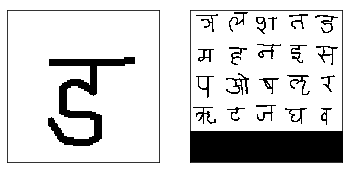

In [0]:
# Plot 20 way one-shot learning pair for Sanskrit Language
pairs, targets = make_oneshot_task(20, "train", "Sanskrit")
plot_oneshot_task(pairs)

In [0]:
# Evaluate the accuracy for 250 random 20 way One-shot learning tasks

acc = test_oneshot(model, 20, 250, s='Sanskrit', verbose=True)

Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 

